# Decision Tree Methods

## Related Work

Montevechi, A. A., Miranda, R. de C., Medeiros, A. L., & Montevechi, J. A. B. (2024). Advancing credit risk modelling with machine learning: A comprehensive review of the state-of-the-art. Engineering Applications of Artificial Intelligence, 137(Part A), 109082. https://doi.org/10.1016/j.engappai.2024.109082

Chang, Y.-C., Chang, K.-H., Chu, H.-H., & Tong, L.-I. (2016). Establishing decision tree-based short-term default credit risk assessment models. Communications in Statistics - Theory and Methods, 45(23), 6803–6815. https://doi.org/10.1080/03610926.2014.968730


Chang et al. (2016) proposed a decision tree-based credit risk assessment model specifically designed to identify short-term defaults. The model integrates Bagging and SMOTE techniques to enhance stability and performance. Unlike traditional models that assess long-term default risk or rely on survival analysis, this binary classification approach focuses on short-term loss prevention—enabling financial institutions to take timely actions on high-risk cases.

The model demonstrated superior recall compared to logistic regression and Cox models, effectively capturing around 7% of cases prone to short-term default. It also offers transparent classification rules that align with practical lending decisions and requires no significant computing resources. The authors highlight the model's applicability in real-world financial institutions and suggest future work on extremely low-default corporate portfolios to validate its robustness further.

A more recent review on credit risk modelling by Montevechi et al. (2024) note that no single ML model outperforms others consistently in credit risk prediction. However, Decision Trees (DT), Random Forests (RF), and boosting ensembles are among the most commonly used due to their relative interpretability. More complex models like neural networks (NN) offer high accuracy but are harder to understand and deploy under current regulatory expectations.

## Why Decision Tree Methods are suitable for Credit Card Approval Prediction

In this file, we will be focusing on decision tree-based models. The goal of this project is to classify clients as "Good" or "Bad" credit risks using a credit scoring dataset. The classification task is binary in nature, and decision trees are well-suited for this type of problem due to their ability to model non-linear relationships and provide interpretable results.

We begin with a basic Decision Tree Classifier as a baseline model, and progressively explore more advanced ensemble variants, namely Random Forest, XGBoost, and LightGBM. These models build upon the foundation of decision trees, enhancing performance through techniques such as bagging (in the case of Random Forest) and boosting (in XGBoost and LightGBM). Lastly, we build ensemble stacking methods which combines the predictions of multiple base models.

An important challenge in this dataset is class imbalance, where "Good" clients significantly outnumber "Bad" ones. This imbalance can cause models to be biased toward predicting the majority class, leading to poor generalization on the minority class. To address this, we applied SMOTE (Synthetic Minority Over-sampling Technique) on the training set to synthetically generate new samples of the minority ("Bad") class, aiming to balance the class distribution. 

However, while SMOTE helps the model see more examples of the minority class during training, it does not guarantee that the learned decision boundaries will generalize well to real unseen data. Synthetic samples may not perfectly capture the true distribution of the minority class, which can lead to overfitting or learned patterns that do not transfer well. As a result, the models may still exhibit bias, especially if the minority class overlaps significantly with the majority class. This presents a technical limitation that must be carefully considered when evaluating model performance.

Since there is a class imbalance, accuracy would not be a good metric to focus on as the model can simply predict 'Good' for most clients and still achieve a high accuracy. In this case, it might fail to identify 'Bad" clients.

In our models, we want the model to perform well on both minimizing false positives (Precision) and false negatives (Recall) for the 'Bad' clients. Hence, we will pick F1-score as the primary metric to evaluate our models as it is the harmonic mean of precision and recall and helps balance the two. 

## Model Implementation

In [2]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Reading files
train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

In [4]:
train_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,IS_EMPLOYED,TYPE
0,1,1,0,-0.579661,-0.728827,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Unknown,-0.217680,1.106810,0,1
1,0,0,1,-0.579661,-0.728827,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Unknown,-0.217680,1.541205,0,1
2,0,0,0,-0.579661,-0.242521,Commercial associate,Secondary / secondary special,Married,House / apartment,1,1,0,0,Core staff,-0.217680,-0.543892,1,1
3,0,0,0,-0.579661,0.376413,Pensioner,Higher education,Married,House / apartment,1,0,0,1,Unknown,-0.217680,1.019931,0,1
4,0,1,1,0.767400,0.730090,State servant,Higher education,Married,House / apartment,1,0,0,0,Managers,0.879204,-0.196376,1,1


In [5]:
# Split train and test data into feature and response variables
X_train = train_df.drop(columns=["TYPE"])
y_train = train_df["TYPE"]
X_test = test_df.drop(columns=["TYPE"])
y_test = test_df["TYPE"]

In [6]:
# Look at column types
train_df.dtypes

CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN           float64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE                    float64
IS_EMPLOYED              int64
TYPE                     int64
dtype: object

In [7]:
# Encode categorical variables using One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

categorical_cols = train_df.select_dtypes(include=["object"]).columns

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert back to DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

# Drop original categorical columns and concatenate encoded ones
X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True).join(X_train_encoded)
X_test = X_test.drop(columns=categorical_cols).reset_index(drop=True).join(X_test_encoded)


In [8]:
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff
0,1,1,0,-0.579661,-0.728827,1,0,0,0,-0.217680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,1,-0.579661,-0.728827,1,0,0,0,-0.217680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,-0.579661,-0.242521,1,1,0,0,-0.217680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,-0.579661,0.376413,1,0,0,1,-0.217680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1,1,0.767400,0.730090,1,0,0,0,0.879204,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Decision Tree (Baseline)

In [9]:
# Implement a decision tree without any modifications
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create and train the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.2283    0.3500    0.2763        60
           1     0.9946    0.9902    0.9924      7232

    accuracy                         0.9849      7292
   macro avg     0.6114    0.6701    0.6343      7292
weighted avg     0.9883    0.9849    0.9865      7292



This baseline decision tree is trained using gini impurity as the loss function.

While the model achieves a high overall accuracy of 0.9849, this metric can be misleading in the presence of severe class imbalance.

We take a closer look at the class-wise F1-scores:

For the majority class ("Good" clients), the model performs exceptionally well with an F1-score of 0.9924. However, for the minority class ("Bad" clients), the F1-score drops significantly to just 0.2763.

This indicates that while the model is highly effective at identifying good clients, it struggles to correctly detect bad clients. The low F1-score for the "Bad" class suggests a poor balance between precision and recall. Ideally, we want to maximise recall to correctly identify as many "Bad" clients as possible and also maintain a good precision to not wrongly classify too many good clients as bad.

Moving forward, we apply ensemble methods to try to increase the f1-score for the "Bad" clients.

## Random forest

In [10]:
# Implement a random forest model
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation metrics

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred,digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.3333    0.3000    0.3158        60
           1     0.9942    0.9950    0.9946      7232

    accuracy                         0.9893      7292
   macro avg     0.6638    0.6475    0.6552      7292
weighted avg     0.9888    0.9893    0.9890      7292



Random Forest is an ensemble learning technique (Bagging) that builds multiple decision trees on different subsets of the data and features, and aggregates their predictions through majority voting for classification tasks. By considering only a random subset of features for each split, Random Forest introduces diversity among the individual trees, helping to reduce variance and mitigate overfitting, which is often a limitation of single decision trees.

Using random forest, f1-score for the 'Bad' clients improved slightly to 0.3158 from 0.2763. When we look at the precision and recall for "Bad" clients, precision increased, meaning that when the model predicts a client as "Bad", it is more likely to be correct. Recall decreased, indicating that the model is now identifying fewer actual "Bad" clients compared to the baseline.

We now apply hyperparameter tuning to attempt to improve these results.


In [11]:
# Hyperparameter tuning for random forest model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# Define the base model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Custom scorer for GridSearchCV. Optimizes for f1-score of 'Bad' clients.
f1_for_bad_clients = make_scorer(f1_score, pos_label=0)

# Possible values for max_depth of trees
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
}

# Search for best max_depth
grid_search = GridSearchCV(
    rf, param_grid,
    scoring=f1_for_bad_clients,  # Optimizing for F1-score for 'Bad' clients
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors for faster computation
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train the random forest model using the best max_depth
best_rf_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_rf_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Best Parameters: {'max_depth': 40}
Classification Report:
              precision    recall  f1-score   support

           0     0.3396    0.3000    0.3186        60
           1     0.9942    0.9952    0.9947      7232

    accuracy                         0.9894      7292
   macro avg     0.6669    0.6476    0.6566      7292
weighted avg     0.9888    0.9894    0.9891      7292



During hyperparameter tuning, we set the objective function to be maximised as the f1-score for "Bad" clients. By performing a grid search on a list of varing max_depth for individual trees, we observe that decision trees of max_depth 40 performs the best in the random forest model.

After hyperparameter tuning, f1-score improved from 0.3158 to 0.3186. Precision for the "Bad" clients increased but recall remains the same. 

By reducing the max_depth of trees, we are able to reduce the complexity of individual trees, which helps to mitigate overfitting. A simpler model is less prone to capturing noise from the training data and more likely to generalize better to unseen data, which is reflected in the slight improvement of the f1-score.

To further improve f1-scores for "Bad" clients, we look for the optimal threshold to maximise f1-score for "Bad" clients. Currently, the default decision threshold is 0.5, meaning any instance with a predicted probability ≥ 0.5 for the positive class ("Good" clients) is classified as "Good", and anything below is classified as "Bad". However, this default threshold does not always yield optimal results, especially in our imbalanced dataset where "Bad" clients are underrepresented.

Best threshold for F1 (Bad Clients): 0.56
Best F1 Score for Bad Clients: 0.3520


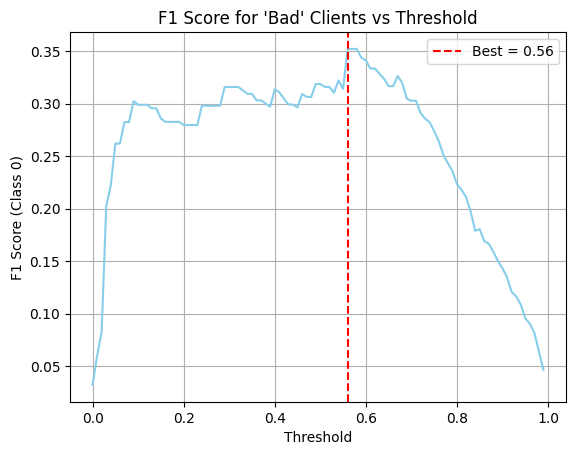

In [12]:
# Find optimal threshold to maximise f1-score for "Bad" clients

# Predict probabilities for the test set
y_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Try different thresholds
thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=0)  # F1 for 'Bad'
    f1_scores.append(f1)

# Get best threshold
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best threshold for F1 (Bad Clients): {best_thresh:.2f}")
print(f"Best F1 Score for Bad Clients: {best_f1:.4f}")

# Plot
plt.plot(thresholds, f1_scores, color="skyblue")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best = {best_thresh:.2f}")
plt.title("F1 Score for 'Bad' Clients vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Class 0)")
plt.grid(True)
plt.legend()
plt.show()


In [13]:
# Use the optimal threshold for prediction

y_pred_final = (y_proba > best_thresh).astype(int)

print("Classification Report with Best Threshold:")
print(classification_report(y_test, y_pred_final, digits=4))


Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0     0.3385    0.3667    0.3520        60
           1     0.9947    0.9941    0.9944      7232

    accuracy                         0.9889      7292
   macro avg     0.6666    0.6804    0.6732      7292
weighted avg     0.9893    0.9889    0.9891      7292



We vary the threshold for classifying "Good" and "Bad" clients to find the optimal threshold that maximises f1-score for "Bad" clients. Using this optimal threshold for classification (0.56), we see that the f1-score for "Bad" clients increased from 0.3186 to 0.3520, showing better detection of the minority class. Now both precision and recall for the "Bad" clients are both higher than the baseline decision tree model.

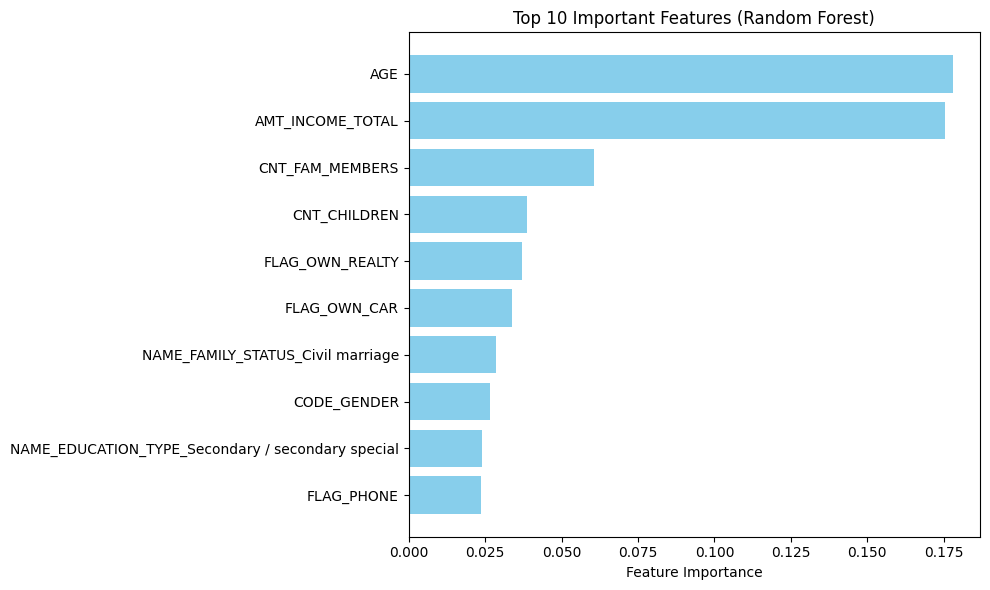

In [34]:
# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features (Random Forest)')
plt.tight_layout()
plt.show()


This plot shows the top 10 most important features identified by the Random Forest model. Feature importance is determined based on how much each feature contributes to reducing impurity across all trees in the ensemble. From the plot, we see that "AGE" and "AMT_INCOME_TOTAL" are the most important features in predicting whether a client is classified as "Good" or "Bad", indicating that a client’s age and total income have the highest influence on the model’s classification of credit risk.

## Boosting Models

Boosting is an ensemble technique that trains models sequentially, where each new tree focuses on correcting the mistakes made by the previous ones. By giving more weight to the misclassified instances at each iteration, boosting is effective at reducing bias and improving overall predictive performance. In this section, we experiment with two widely-used gradient boosting algorithms: XGBoost and LightGBM, both known for their robustness and efficiency, especially in structured data tasks like credit risk classification.

## XGBoost

In [14]:
# Implement XGboost model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Create and train the XGBoost model
clf = XGBClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation metrics
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.1163    0.3333    0.1724        60
           1     0.9944    0.9790    0.9866      7232

    accuracy                         0.9737      7292
   macro avg     0.5553    0.6562    0.5795      7292
weighted avg     0.9872    0.9737    0.9799      7292



XGBoost without any hyperparameter tuning performs badly on the test data, with a f1-score of 0.1724 for 'Bad' clients.

We perform hyperparameter tuning to improve model performance next.

In [15]:
# Hyperparameter tuning for XGboost model

# Define the base XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Custom scorer for GridSearchCV. Optimizes for f1-score of 'Bad' clients.
f1_for_bad_clients = make_scorer(f1_score, pos_label=0)

# Set up hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 6, 7, 8, 9, 10, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
}

# Set up GridSearchCV with F1 score as the scoring metric
grid_search = GridSearchCV(
    xgb_model, param_grid,
    scoring=f1_for_bad_clients,  # Optimize for F1 score for 'Bad' clients
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

# Fit the grid search model to training data
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model and make predictions
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Print classification report to evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Best Parameters: {'learning_rate': 0.2, 'max_depth': 15}
Classification Report:
              precision    recall  f1-score   support

           0     0.3284    0.3667    0.3465        60
           1     0.9947    0.9938    0.9943      7232

    accuracy                         0.9886      7292
   macro avg     0.6615    0.6802    0.6704      7292
weighted avg     0.9893    0.9886    0.9889      7292



We perform a grid search on a range of values for the max_depth of each trained tree as well as the learning rate. The objective function that is maximised is the f1-score for "Bad" clients. We then train the XGBoost model using the optimal parameters.

After hyperparameter tuning, f1-score improved from 0.1724 to 0.3465, which is a good improvement. Comparing to our best model currently (Random forest with tuned hyperparameter and threshold), XGBoost performed slightly worse with a lower f1-score for "Bad" clients and a lower precision. Recall remains the same.

Next we explore a LightGBM model.

## LightGBM

In [24]:
# Original lightgbm without hyperparameter tuning
import lightgbm as lgb

# Define LightGBM classifier:
clf = lgb.LGBMClassifier(random_state = 42, verbose = -1)

clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation metrics
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.0878    0.3000    0.1358        60
           1     0.9941    0.9741    0.9840      7232

    accuracy                         0.9686      7292
   macro avg     0.5409    0.6371    0.5599      7292
weighted avg     0.9866    0.9686    0.9770      7292



Similarly to XGBoost, LightGBM performs poorly on the test data, with a 0.1358 f1-score for "Bad" clients.

We proceed to perform hyperparameter tuning.

In [25]:
# Lightgbm with hyperparameter tuning

# Define LightGBM classifier:
lgb_model = lgb.LGBMClassifier(random_state = 42, verbose = -1)

'''
# hyperparameter grid for lightGBM
lgb_param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}
'''

lgb_param_grid = {
    'num_leaves': [31, 100],                     # Drop 50 (middle value)
    'learning_rate': [0.01, 0.1],                # Keep low + high
    'n_estimators': [100],                       # Fix to 100
    'subsample': [0.8],                          # Fix to most common good value
    'colsample_bytree': [0.8, 1.0],              # Keep both
    'reg_alpha': [0, 0.1],                       # Light regularization
    'reg_lambda': [0, 0.1]                       # Same here
}

# GridSearchCV
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    cv=5, # 5 fold cross validation
    scoring=f1_for_bad_clients,# same as above
    n_jobs = -1,
    verbose=1
)

# fit gridsearch
lgb_grid_search.fit(X_train, y_train)

# best hyperparams
print("Best Parameters:", lgb_grid_search.best_params_)

# Get the best model and make predictions
best_lgb = lgb_grid_search.best_estimator_
y_pred = best_lgb.predict(X_test)

# Print classification report to evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0     0.3556    0.2667    0.3048        60
           1     0.9939    0.9960    0.9950      7232

    accuracy                         0.9900      7292
   macro avg     0.6747    0.6313    0.6499      7292
weighted avg     0.9887    0.9900    0.9893      7292



Using the optimal hyperparameters to train the LightGBM model, the f1-score improved from 0.1358 to 0.3048. However, it is still not as good as XGBoost or Random Forest.

LightGBM is known for its faster training and lower memory usage. In our case, the model's leaf-wise tree growth may have contributed to slight overfitting, resulting in lower generalization to the minority class compared to the other ensemble methods.

## Stacking

Stacking is an ensemble learning technique that combines the predictions of multiple base models (called level-0 models) and uses a meta-model (called level-1 model) to make the final prediction. Each base model learns from the original training dataset independently, and their outputs are then used as inputs for the meta-model. In our case, we use logistic regression as the meta-model, which takes predicted probabilities from the base models as input and learns to assign optimal weights to each, effectively learning how to best combine their outputs to make the final classification. This helps improve overall model performance by leveraging the strengths of each base learner while minimizing their individual weaknesses. For example, if XGBoost is better at detecting “Bad” clients and LightGBM is stronger for “Good” clients, Logistic Regression can learn to rely more on XGBoost when a case looks like a “Bad” client. 

In [ ]:
# Get the tuned XGBoost, LightGBM and Random forest models
best_xgb = grid_search.best_estimator_
best_lgb = lgb_grid_search.best_estimator_
best_rf = best_rf_model

## Stacking Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Define base estimators
estimators = [
    ('xgb', best_xgb),
    ('lgb', best_lgb)
]

# Create and train a stacking classifier with LogisticRegression as the final estimator
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

# Print classification report to evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred_stack, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.3673    0.3000    0.3303        60
           1     0.9942    0.9957    0.9950      7232

    accuracy                         0.9900      7292
   macro avg     0.6808    0.6479    0.6626      7292
weighted avg     0.9890    0.9900    0.9895      7292



We implement a Stacking Classifier with both boosting models (XGBoost and LightGBM) as the base models.

This model achieves a f1-score of 0.3303 for "Bad" clients, offering a higher precision compared to XGBoost alone but with a lower recall.

Next we try a different combination of baseline models.

In [32]:
# Define base estimators
estimators2 = [
    ('xgb', best_xgb),
    ('lgb', best_lgb),
    ('rf', best_rf)
]

# Create and train a stacking classifier with LogisticRegression as the final estimator
stacking_clf2 = StackingClassifier(
    estimators=estimators2,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacking_clf2.fit(X_train, y_train)
y_pred_stack = stacking_clf2.predict(X_test)

# Print classification report to evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred_stack, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.4091    0.3000    0.3462        60
           1     0.9942    0.9964    0.9953      7232

    accuracy                         0.9907      7292
   macro avg     0.7016    0.6482    0.6707      7292
weighted avg     0.9894    0.9907    0.9900      7292



We use XGBoost, LightGBM and Random forest as the baseline models and obtained an f1-score of 0.3462, which is an improvement from our previous model. However, f1-score and recall is still lower for "Bad" clients compared to the random forest model we implemented previously. We note that precision for this model is higher than precision in our random forest model.

## Conclusion

Summarizing our findings above, we find that for "Bad" clients:

Random forest with hyperparameter and threshold tuning obtained the highest f1-score of 0.3520 and highest recall of 0.3667.

Stacking Classifier using XGBoost, LightGBM and Random Forest obtained the highest precision of 0.4091.

For our problem objective, we are more focused on maximising recall so that we can identify as many "Bad" clients as possible. In this case, we pick Random forest to be our best model.

## Future Recommendations

1) Incorporating additional features or performing advanced feature engineering may enhance model performance.

2) Fine-tuning the models further with additional hyperparameters, such as learning rate decay or boosting iterations, could further improve f1-score, precision, and recall.